<a href="https://colab.research.google.com/github/xxilytoo/IgniteAI-Song-Recommendation-Project/blob/main/NLPEmotionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("tweet_emotions.csv")
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
df = df.drop(columns=["tweet_id"])
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
df.tail()

,sentiment,content
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,love,@mopedronin bullet train from tokyo the gf ...


In [ ]:
df.isnull().sum()

sentiment    0
content      0
dtype: int64

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
df["sentiment"].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [ ]:
df = df[ (df.sentiment == 'happiness') | (df.sentiment == 'sadness') | (df.sentiment == 'love') | (df.sentiment == 'suprise') | (df.sentiment == 'worry')]
df["sentiment"] = df["sentiment"].astype("category")
df.label = df.sentiment.cat.remove_unused_categories()

<ipython-input-195-2f15ad781190>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["sentiment"].astype("category")
<ipython-input-195-2f15ad781190>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.label = df.sentiment.cat.remove_unused_categories()


In [ ]:
sentiment_names = df.sentiment.cat.categories.tolist()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=52)

print(f'{len(train_df)=}, {len(test_df)=}')
print(sentiment_names)

len(train_df)=18140, len(test_df)=4535
['happiness', 'love', 'sadness', 'worry']


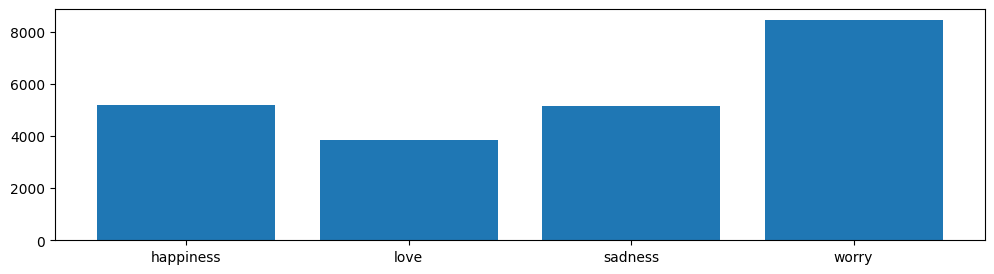

In [ ]:
plt.figure(figsize=(12,3))
plt.bar(x = sentiment_names, height = np.bincount(df['sentiment'].cat.codes))

class_weights = dict(enumerate(
    compute_class_weight(
        class_weight="balanced",
        classes=pd.unique(df['sentiment']),
        y=df['sentiment']
    )
))

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')    # add/remove regex as required
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NUMBERS = re.compile('\d+')

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, 'http\S+', '')
    text = tf.strings.regex_replace(text, '([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)', ' ')
    text = tf.strings.regex_replace(text, '[/(){}\[\]\|@,;]', ' ')
    text = tf.strings.regex_replace(text, '[^0-9a-z #+_]', '')
    text = tf.strings.regex_replace(text, '[\d+]', '')
    return text

def lemmatize_tokenize(text):
    # TODO: rework to use tf.strings
    # remove stopwords and lemmatize
    tokens = [word for word in text.split() if word not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [ ]:
N_CLASSES = len(sentiment_names)
MAX_FEATURES = 20000
MAX_SEQ_LEN = 1000
EMBEDDING_DIM = 100

vectorizer_layer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    standardize=clean_text,
#     split=lemmatize_tokenize,
    output_sequence_length=MAX_SEQ_LEN,
    output_mode='int'
)
vectorizer_layer.adapt(train_df.content)

In [ ]:
# Download and load pre-trained GloVe embeddings
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [ ]:
# Load GloVe embeddings into memory
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Get the vocabulary from the vectorizer layer
vocabulary = vectorizer_layer.get_vocabulary()

# Create a mapping from token to index
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Create embedding matrix
embedding_matrix = np.zeros((len(vocabulary), EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_FEATURES:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
model = models.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    vectorizer_layer,
    layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),

    layers.SpatialDropout1D(0.2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='gelu'),
    layers.Dropout(0.4),
    layers.Dense(N_CLASSES, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
X_train, y_train = train_df.content, train_df.sentiment.cat.codes
X_test,  y_test  =  test_df.content,  test_df.sentiment.cat.codes

history = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=300,
    verbose=1,
    class_weight=class_weights,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/300
71/71 [==============================] - 38s 514ms/step - loss: 1.4414 - accuracy: 0.3652 - val_loss: 1.3638 - val_accuracy: 0.3669
Epoch 2/300
71/71 [==============================] - 34s 482ms/step - loss: 1.3842 - accuracy: 0.3837 - val_loss: 1.2789 - val_accuracy: 0.4130
Epoch 3/300
71/71 [==============================] - 42s 593ms/step - loss: 1.2580 - accuracy: 0.4641 - val_loss: 1.1571 - val_accuracy: 0.4664
Epoch 4/300
71/71 [==============================] - 44s 606ms/step - loss: 1.1563 - accuracy: 0.5024 - val_loss: 1.1266 - val_accuracy: 0.4778
Epoch 5/300
71/71 [==============================] - 38s 530ms/step - loss: 1.0816 - accuracy: 0.5518 - val_loss: 1.1148 - val_accuracy: 0.4900
Epoch 6/300
71/71 [==============================] - 35s 490ms/step - loss: 1.0074 - accuracy: 0.5912 - val_loss: 1.1062 - val_accuracy: 0.4937
Epoch 7/300
71/71 [==============================] - 36s 507ms/step - loss: 0.9358 - accuracy: 0.6230 - val_loss: 1.1237 - val_accuracy:

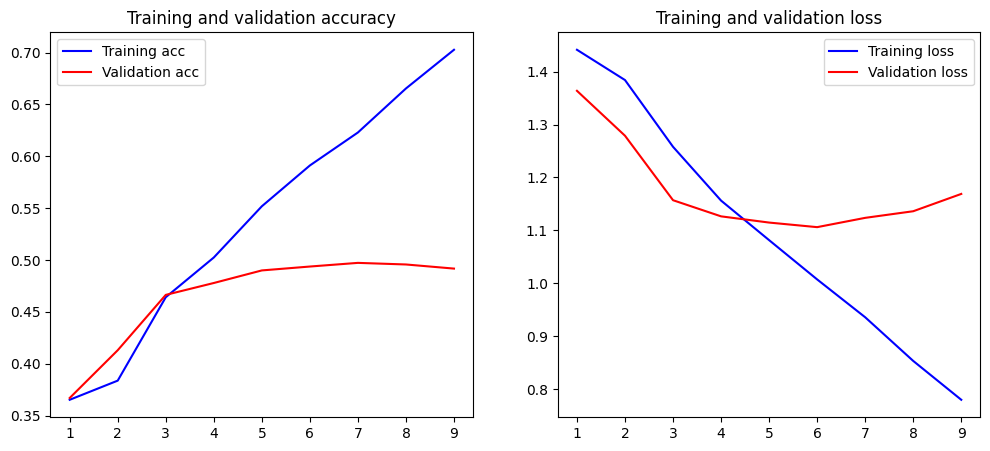

In [ ]:
def plot_history(history):
    acc,  val_acc  = history['accuracy'],  history['val_accuracy']
    loss, val_loss = history['loss'], history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)

    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy'); plt.legend(); plt.subplot(1, 2, 2)

    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss'); plt.legend(); plt.show()

plot_history(history.history)

142/142 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

   happiness       0.49      0.54      0.51      1062
        love       0.65      0.28      0.39       786
     sadness       0.40      0.45      0.42      1023
       worry       0.52      0.59      0.55      1664

    accuracy                           0.49      4535
   macro avg       0.52      0.46      0.47      4535
weighted avg       0.51      0.49      0.49      4535



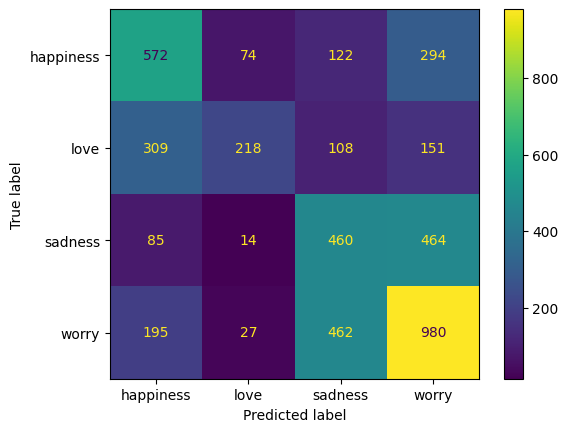

In [ ]:
y_pred = model.predict(X_test).argmax(1)

print(classification_report(
    y_test, y_pred, target_names= sentiment_names
))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels = sentiment_names
)